In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt -q

In [1]:
import pandas as pd
import numpy as np
from math import ceil

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Посмотрим на первые 5 строчек представленного датасета

In [2]:
df = pd.read_csv('predict.csv')
df.head()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,authors_mean_pagerank,authors_mean_productivity,journal_pagerank,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
0,16,1.0,-0.425436,500.0,1.0,1.0,6.0,NaN,NaN,NaN,101.0,66,1653,7,1.0,1.945910
1,8,7.0,-0.571967,134.0,1.0,1.0,6.0,NaN,NaN,NaN,24.0,59,1527,7,32.0,1.945910
2,15,19.0,-0.859644,235.0,1.0,1.0,5.0,NaN,NaN,NaN,49.0,169,1554,6,5.0,1.791759
3,6,4.0,-1.054999,1124.0,1.0,1.0,10.0,NaN,NaN,NaN,185.0,130,2121,11,7.0,2.397895
4,14,2.0,-0.476697,346.0,1.0,1.0,2.0,NaN,NaN,NaN,72.0,100,432,3,7.0,1.098612


Сразу же в глаза бросаются колонки с пустыми значениями *authors_mean_pagerank*, *authors_mean_productivity* и *journal_pagerank*. Рассмотрим сколько пропущенных данных есть в каждом столбце

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   recency                     479 non-null    int64  
 1   topic_rank                  479 non-null    float64
 2   diversity                   479 non-null    float64
 3   authors_mean_rank           473 non-null    float64
 4   authors_mean_hindex         473 non-null    float64
 5   authors_mean_gindex         473 non-null    float64
 6   authors_mean_sociality      473 non-null    float64
 7   authors_mean_pagerank       0 non-null      float64
 8   authors_mean_productivity   0 non-null      float64
 9   journal_pagerank            0 non-null      float64
 10  journal_rank                440 non-null    float64
 11  title_len                   479 non-null    int64  
 12  abstract_len                479 non-null    int64  
 13  n_authors                   479 non

Три столбца оказались не заполненными, удалим их, а затем посмотрим на процент пропущенных значений в оставшихся стобцах

In [4]:
df = df.dropna(how='all', axis=1)
df.head()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
0,16,1.0,-0.425436,500.0,1.0,1.0,6.0,101.0,66,1653,7,1.0,1.945910
1,8,7.0,-0.571967,134.0,1.0,1.0,6.0,24.0,59,1527,7,32.0,1.945910
2,15,19.0,-0.859644,235.0,1.0,1.0,5.0,49.0,169,1554,6,5.0,1.791759
3,6,4.0,-1.054999,1124.0,1.0,1.0,10.0,185.0,130,2121,11,7.0,2.397895
4,14,2.0,-0.476697,346.0,1.0,1.0,2.0,72.0,100,432,3,7.0,1.098612


In [5]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

recency - 0%
topic_rank - 0%
diversity - 0%
authors_mean_rank - 1%
authors_mean_hindex - 1%
authors_mean_gindex - 1%
authors_mean_sociality - 1%
journal_rank - 8%
title_len - 0%
abstract_len - 0%
n_authors - 0%
c5 - 0%
log_authors_mean_sociality - 1%


Всё выглядит достаточно безобидно, лишь столбец *journal_rank* имеет наибольшее количество пропущенных значений, по сравнению с другими.

Прежде чем находить объекты с большим количеством пропущенных значений, рассмотрим корреляцию признаков.

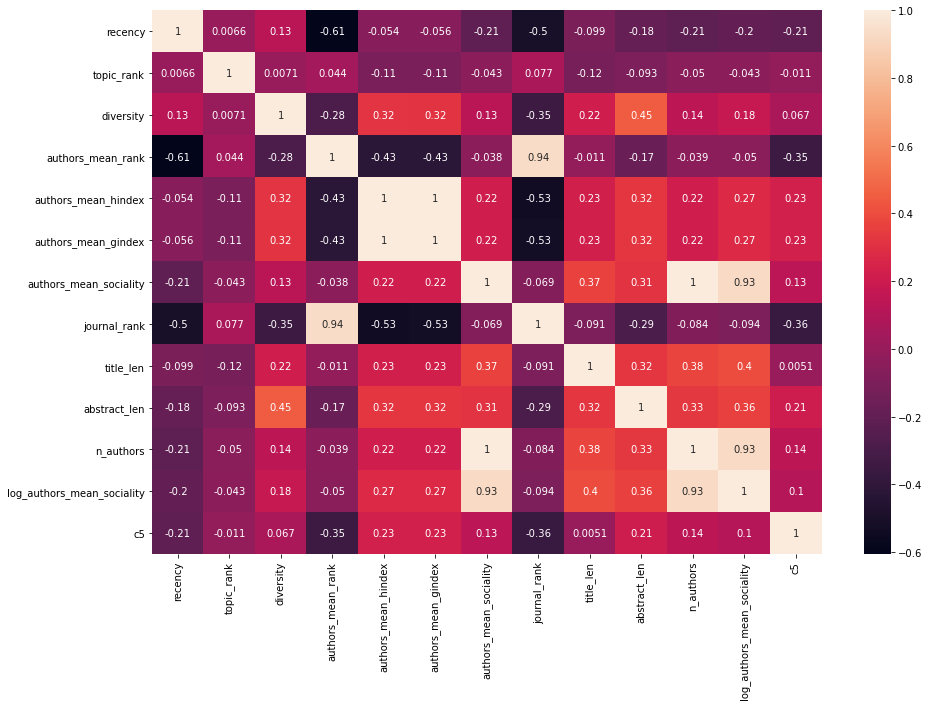

In [6]:
#Для удобства сделаем предсказываемый признак последним
df = df.reindex(columns=(
    list([elem for elem in df.columns if elem != 'c5'] + ['c5'])
))

plt.figure(figsize=(15,10))
hm = sns.heatmap(df.corr(),
                 cbar=True,
                 annot=True)

Имеется целый набор сильно коррелируемых признаков:
1. *n_authors*, *authors_mean_sociality*, *log_authors_mean_sociality*
2. *authors_mean_hindex*, *authors_mean_gindex*
3. *authors_mean_rank*, *journal_rank*

Из первого набора будет оставлен признак *n_authors*, так как он не имеет пропущенных значений.

Из второго оставим признак *authors_mean_hindex*.

Из третьего набора оставим *authors_mean_rank*, так как он имеет меньше пропущенных значений.

In [7]:
df = df.drop(['authors_mean_gindex', 'authors_mean_sociality', 'log_authors_mean_sociality',
              'journal_rank'], axis=1)

Теперь посмотрим, сколько объектов имеют пропущенные значения и в каком количестве

created missing indicator for: authors_mean_rank
created missing indicator for: authors_mean_hindex


<AxesSubplot:xlabel='index'>

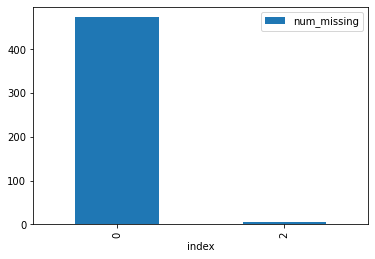

In [8]:
for col in df.columns:
    missing = df[col].isna()
    num_missing = np.sum(missing)
    if num_missing > 0:
        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index() \
    .sort_values(by='index') \
    .plot.bar(x='index', y='num_missing')

Лишь несколько объектов имеют 2 пропущенных признака, заполним пропуски значением медианы признака.

In [9]:
cols_with_nan = df.columns[df.isna().any()].tolist()
for col in cols_with_nan:
    med = df[col].median()
    df[col] = df[col].fillna(med)
df = df[df.columns.drop(list(df.filter(regex='missing')))]

Посмотрим, есть ли стобцы, имеющие более 95% одинаковых значений.

In [10]:
num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Таким стобцов нет. Теперь с помощью диаграмм размаха для каждого признака найдём выбросы

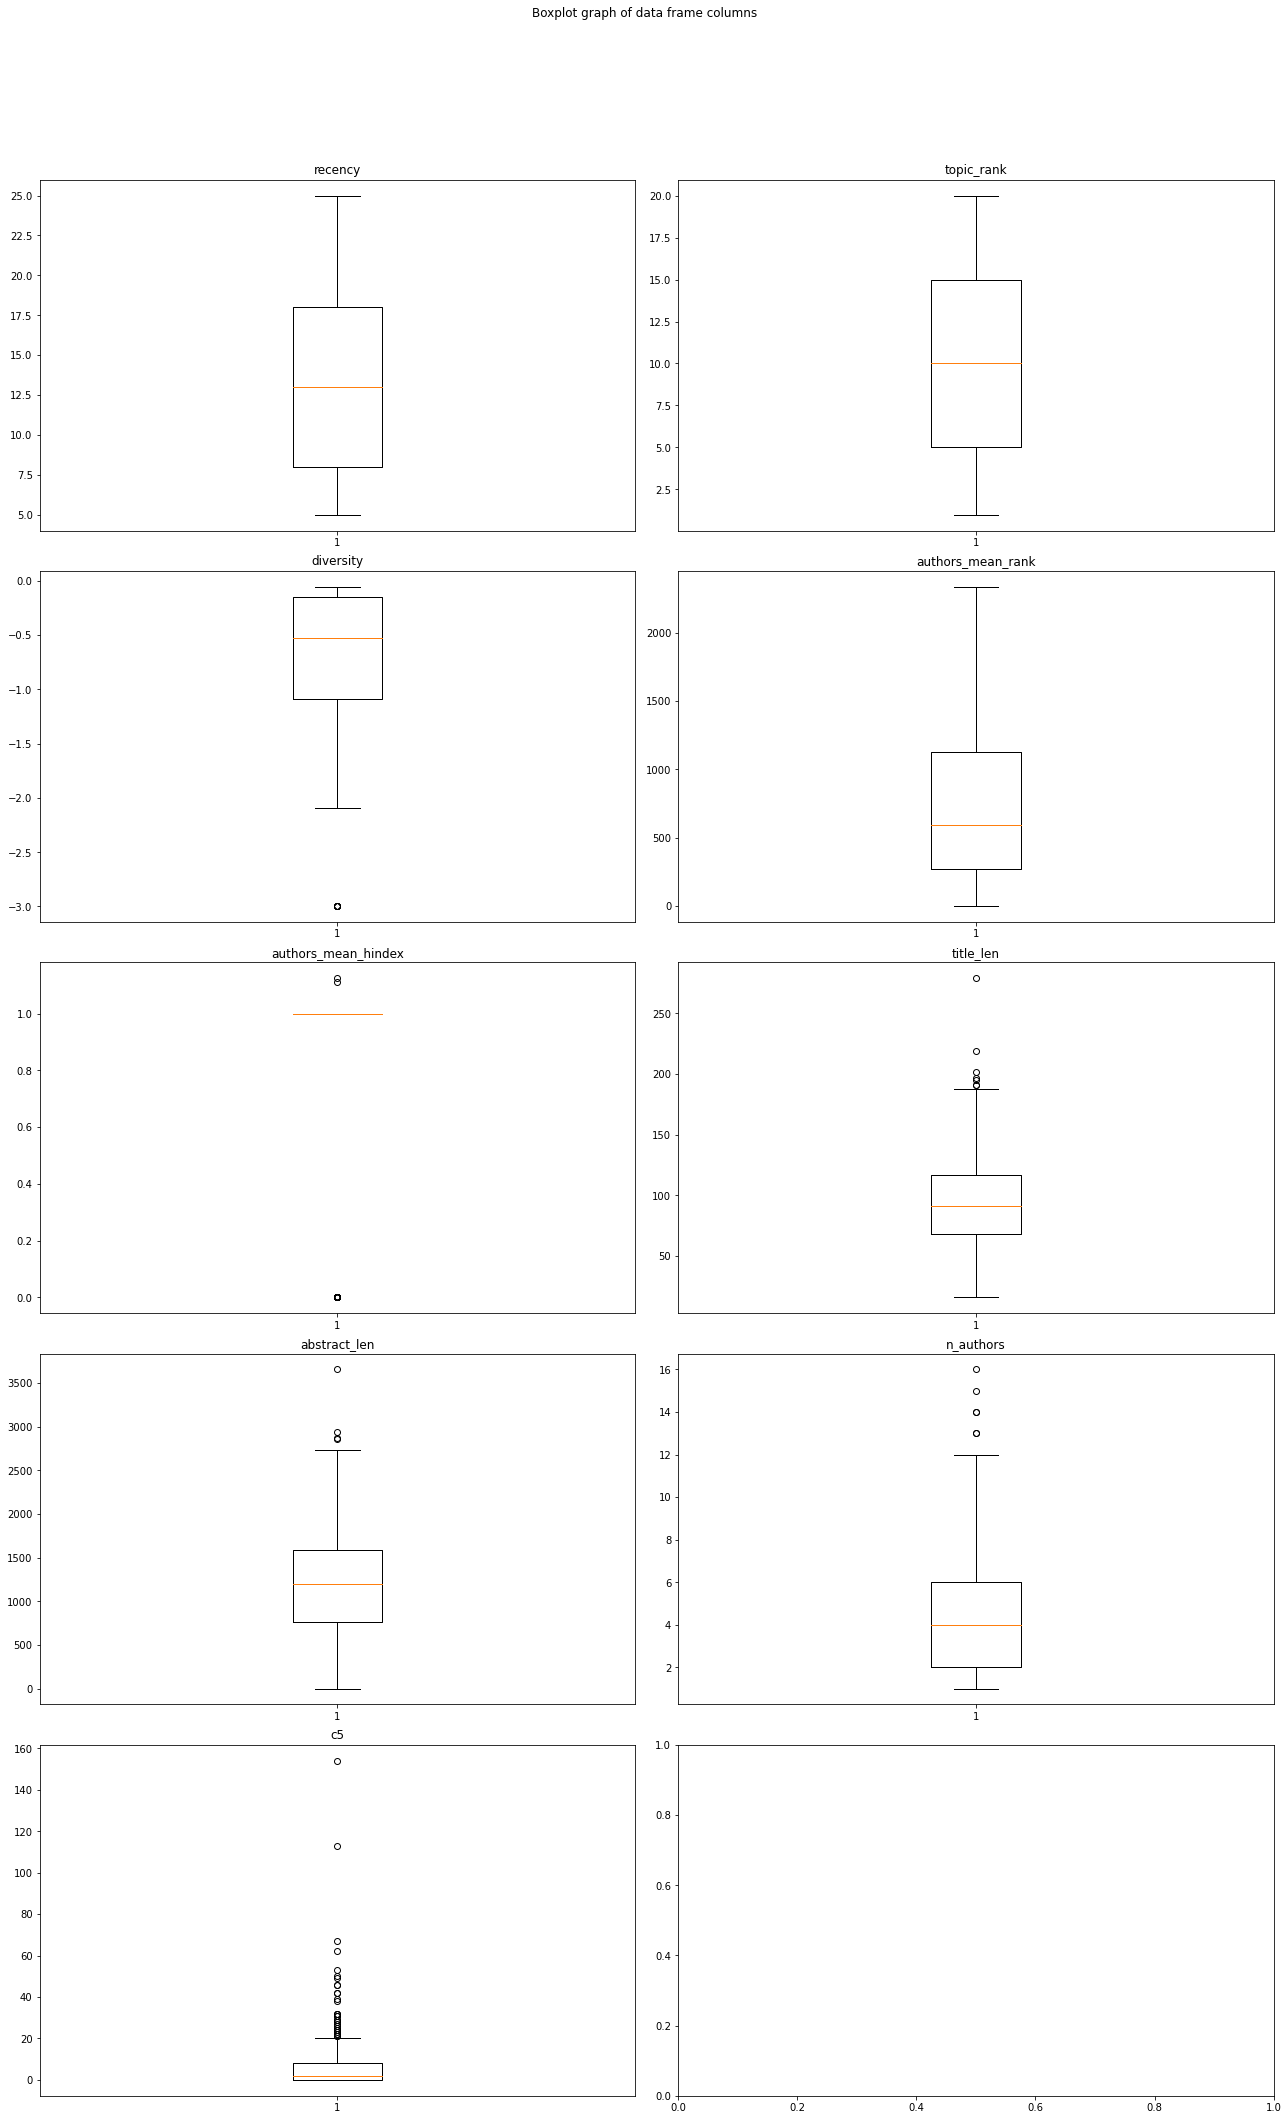

In [11]:
fig, axes = plt.subplots(ceil(len(df.columns.values) / 2), 2, figsize=(18, 30))
axes = np.delete(np.ravel(axes), -1)
for ax, col in zip(axes, df.columns.values):
    ax.boxplot(df[col])
    ax.set_title(col)
plt.suptitle('Boxplot graph of data frame columns')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Для более полной оценки рассмотрим описательную статистику.

In [12]:
df.describe()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,title_len,abstract_len,n_authors,c5
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,13.419624,10.125261,-0.675481,739.943691,0.846004,94.983299,1162.283925,4.369520,6.713987
std,5.860415,5.748655,0.606013,578.512669,0.362086,38.524238,657.597003,2.800775,12.547968
min,5.000000,1.000000,-2.995732,1.000000,0.000000,16.000000,0.000000,1.000000,0.000000
25%,8.000000,5.000000,-1.087146,268.000000,1.000000,68.000000,758.500000,2.000000,0.000000
50%,13.000000,10.000000,-0.526332,596.000000,1.000000,91.000000,1197.000000,4.000000,2.000000
75%,18.000000,15.000000,-0.150066,1129.000000,1.000000,116.500000,1587.500000,6.000000,8.000000
max,25.000000,20.000000,-0.056685,2336.000000,1.125000,279.000000,3655.000000,16.000000,154.000000


Выбросы присутствуют в следующих столбцах: *diversity*, *authors_mean_hindex*, *title_len*, *abstract_len*, *n_authors*, *c5*. Необходимо избавиться от выбросов и сделать это наиболее безболезненным способом. Основываясь на полученных данных, можно сделать следующие выводы:
1. Признак *diversity* ограничить снизу разностью первого квартиля и полутора межквартильных расстояний
2. Признак *authors_mean_hindex* ограничить сверху числом 1, так как подавляющее большинство данных имеют значения 0 и 1.
3. Признаки *title_len*, *abstract_len*, *n_authors*, *c5* ограничить сверху суммой третьего квартиля и полутора межквартильных расстояний

In [13]:
cols = ['diversity', 'title_len', 'abstract_len', 'n_authors', 'c5']
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

condition = (df['diversity'] > Q1['diversity'] - 1.5 * IQR['diversity']) & \
    (df['authors_mean_hindex'] <= 1) & \
    (df['title_len'] < Q3['title_len'] + 1.5 * IQR['title_len']) & \
    (df['abstract_len'] < Q3['abstract_len'] + 1.5 * IQR['abstract_len']) & \
    (df['n_authors'] < Q3['n_authors'] + 1.5 * IQR['n_authors']) & \
    (df['c5'] < Q3['c5'] + 1.5 * IQR['c5'])
    
df = df[condition].reset_index(drop=True)

Так как величина значений различных признаков существенна, стандартизируем их.

In [14]:
scaled_df = df.copy()
features = df.iloc[:, :-1]

scaler = StandardScaler()
scaled_df[features.columns.values] = scaler.fit_transform(features)

In [15]:
scaled_df

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,title_len,abstract_len,n_authors,c5
0,0.392327,-1.574329,0.417962,-0.490488,0.435662,-0.782912,0.839079,1.180740,1.0
1,0.221927,1.538099,-0.360909,-0.953793,0.435662,2.115572,0.680557,0.769196,5.0
2,-1.311680,-1.055591,-0.711333,0.600462,0.435662,1.018088,1.588459,2.826917,7.0
3,0.051526,-1.401416,0.326012,-0.759729,0.435662,0.173869,-1.116033,-0.465437,7.0
4,0.733129,-0.018115,-0.809960,-0.670565,0.435662,0.455275,-0.329825,1.180740,5.0
...,...,...,...,...,...,...,...,...,...
415,1.925934,-0.709765,0.587453,-0.441535,-2.295355,-0.895475,-0.774969,1.180740,0.0
416,-1.311680,0.327711,-1.497870,2.385495,-2.295355,-1.373865,-0.664483,-0.876981,0.0
417,1.755533,1.192274,-1.449151,-0.401324,-2.295355,-0.276381,-1.807768,0.357652,0.0
418,1.755533,-0.709765,-1.611339,-0.401324,-2.295355,-1.064319,-1.807768,-1.288525,0.0


Приступим к построению модели. Будем рассматривать 6 моделей:
* Линейную регрессию
* Логистическую регрессию
* Ридж регрессию
* Регрессию на основе k ближайших соседей
* Версию метода опорных векторов для регрессии
* Модель регрессии случайного леса
* Регрессию, основанную на градиентном бустинге

Изначально с подберём оптимальные параметры для каждой модели, за исключением линейной регресии (самая простая модель).

In [16]:
regressors = (
    LogisticRegression(),
    Ridge(),
    KNeighborsRegressor(),
    SVR(),
    RandomForestRegressor(),
    CatBoostRegressor()
)
titles = (
    'Logistic regression',
    'Ridge regression',
    'K neighnours regression',
    'Epsilon-Support Vector Regression',
    'Random forest regression',
    'CatBoost regression'
)

log_reg_params = {
    'tol': [1e-4, 1e-5],
    'C': [1e-3, 0.01, 0.1, 1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

ridge_params = {
    'alpha': [0.1, 1, 10, 100],
    'max_iter': [1000, 5000],
    'tol': [1e-3, 1e-4],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', \
               'sparse_cg', 'sag', 'saga'],
}

k_neighbors_params = {
    'n_neighbors': range(1, 22, 4),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(10, 101, 10),
    'p': [1, 2, 3]
}

svr_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'tol': [1e-3, 1e-4],
    'C': [1e-3, 0.01, 0.1, 1],
}

forest_params = {
    'n_estimators': [10, 25, 50, 75, 100],
    'criterion': ['mse', 'mae'],
    'max_depth': [5, 6, 7, 8],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

cat_params = {
    'num_trees': [10, 15, 20],
    'learning_rate': [0.03, 0.1, 0.3, 0.5, 1],
    'depth': range(3, 10),
    'border_count': [20, 32, 50, 100, 200]
}
params_set = (
    log_reg_params,
    ridge_params,
    k_neighbors_params,
    svr_params,
    forest_params,
    cat_params
)

X = scaled_df.iloc[:, :-1]
y = scaled_df.iloc[:, -1]

In [17]:
best_models = []
for regressor, title, params in zip(regressors, titles, params_set):
    grid = GridSearchCV(regressor, params, cv=5, n_jobs=-1)
    grid.fit(X, y)
    best_models.append(grid.best_estimator_)
    print('Best parameters for', title, 'are', grid.best_params_)

C:\Users\Mark\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best parameters for Logistic regression are {'C': 1, 'max_iter': 100, 'multi_class': 'auto', 'solver': 'liblinear', 'tol': 0.0001}
Best parameters for Ridge regression are {'alpha': 10, 'max_iter': 5000, 'solver': 'sag', 'tol': 0.001}
Best parameters for K neighnours regression are {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best parameters for Epsilon-Support Vector Regression are {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001}
Best parameters for Random forest regression are {'criterion': 'mse', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0:	learn: 4.4935592	total: 143ms	remaining: 2.71s
1:	learn: 4.1743253	total: 143ms	remaining: 1.29s
2:	learn: 3.6530513	total: 144ms	remaining: 816ms
3:	learn: 3.4084085	total: 145ms	remaining: 579ms
4:	learn: 3.1943178	total: 145ms	remaining: 436ms
5:	learn: 3.0724845	total: 146ms	remaining: 341ms
6:	learn: 2.962370

Сравним полученные модели

In [19]:
best_models = [LinearRegression()] + best_models
titles = (['Linear regression'] + list(titles))

In [20]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left', prop={'size': 12})
    ax.set_title(title)

C:\Users\Mark\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Mark\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


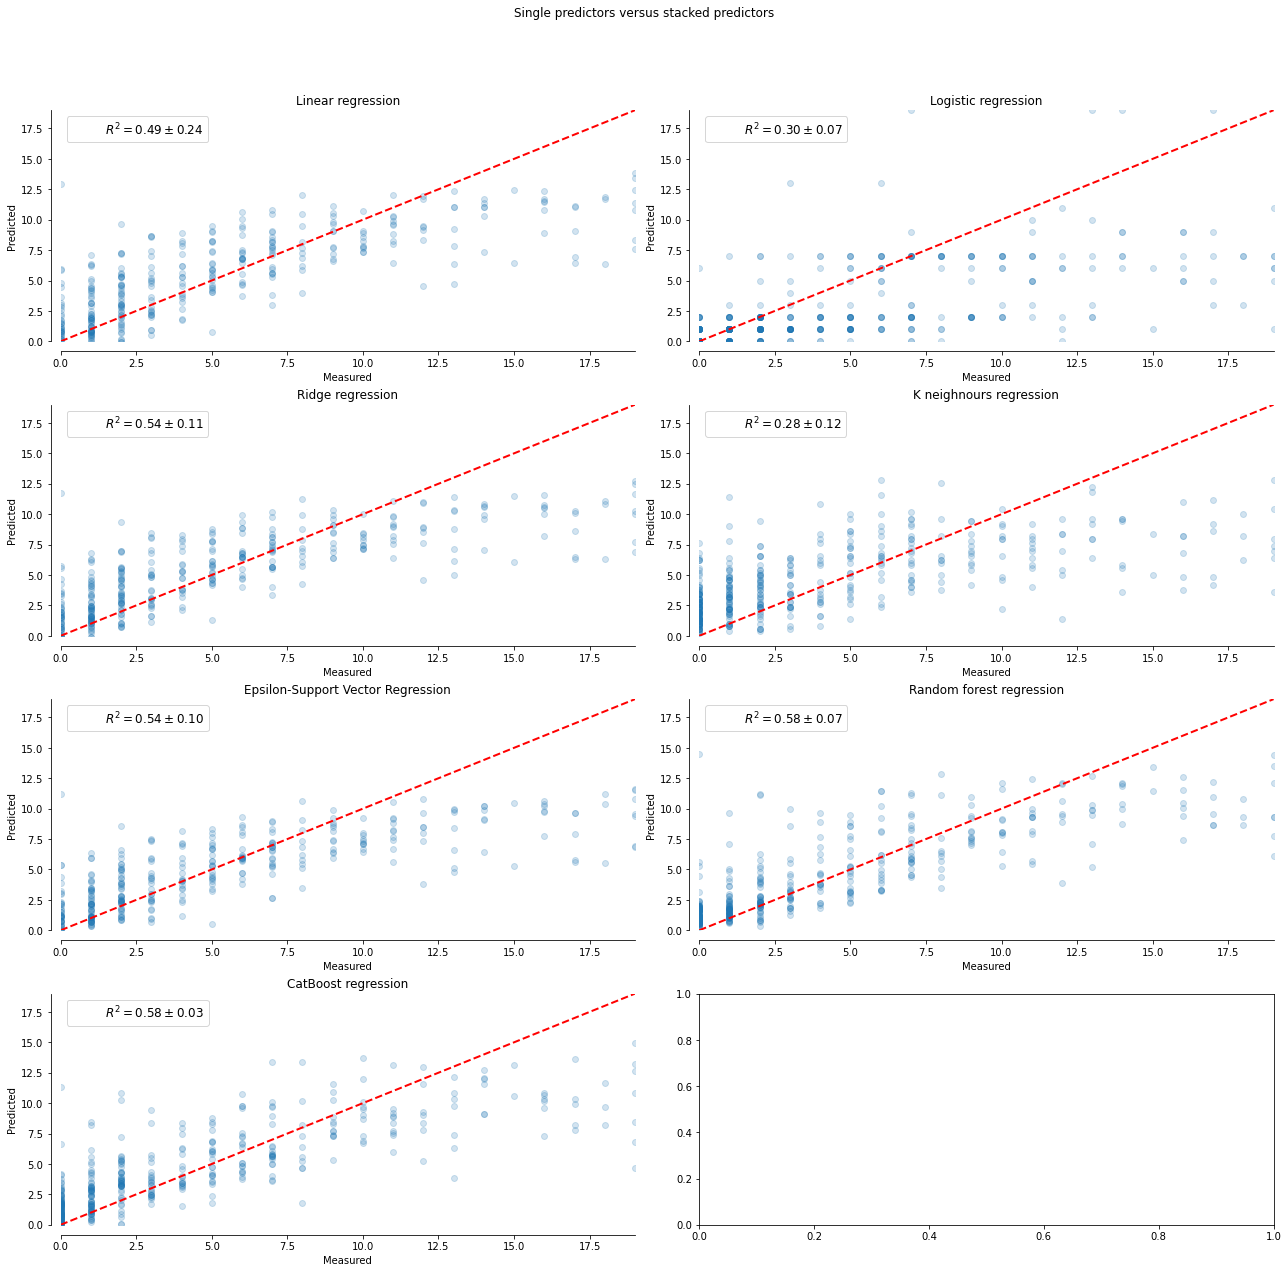

In [21]:
fig, axs = plt.subplots(4, 2, figsize=(18, 18))
axs = np.ravel(axs)
for ax, title, model in zip(axs, titles, best_models):
    score = cross_validate(model, X, y,
                          scoring=['r2'],
                          n_jobs=-1, verbose=0)
    y_pred = cross_val_predict(model, X, y, n_jobs=-1, verbose=0)
    plot_regression_results(
        ax, y, y_pred,
        title,
        (r'$R^2={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2'])))

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Наилучшей моделью оказалась CatBoostRegressor. Она имеет наилучшее качество предсказания R^2 и наименьшее среднеквадратичное отклонение этого параметра.

In [22]:
best = best_models[-1]
print(best)